In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Transform the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset

# Load the data using ImageFolder
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_dataset = torchvision.datasets.ImageFolder(root='./images',
                                                  transform=data_transform)

# Split the data into training and validation sets
train_size = int(0.9 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                           shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                         shuffle=True, num_workers=4)

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}

# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
print(dataset_sizes)
# Get class names associated with labels
class_names = image_dataset.classes

# data_dir = '/Users/shuai/PycharmProjects/Content-Moderation-for-Social-Media/images'
# image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes


In [2]:

# Load the ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully-connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

device_name =  "cpu"
if torch.cuda.is_available():
    device_name = "cuda:0"
if torch.backends.mps.is_available():
    device_name = "mps"

# Move the model to the GPU
device = torch.device(device_name)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay the learning rate by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Keep track of the best model's performance on the validation set
best_acc = 0.0
best_model_wts = model.state_dict()

# # Start the training loop
# for epoch in range(25):
#     print('Epoch {}/{}'.format(epoch, 25 - 1))
#     print('-' * 10)
#
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             scheduler.step()
#             model.train()
#         else:
#             model.eval()

/opt/homebrew/anaconda3/envs/cv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/cv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from torch.cuda import get_device_name
from torch import tensor


def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=25):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            # print(get_device_name(device))
            if device_name== 'mps':
                running_corrects=tensor(running_corrects, device='mps', dtype=torch.float32)
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, './model/best_model.pt')



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [4]:
net = train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=10)
# Load the saved state_dict into the model
# model.load_state_dict(torch.load('./model/best_model.pt'))
# Set the model to evaluation mode
# model.eval()

Epoch 0/9
----------
train Loss: 0.2303 Acc: 0.9214


/var/folders/qf/p1jx3hqj5vv1t6n49gjv_wjw0000gn/T/ipykernel_54745/4238847643.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  running_corrects=tensor(running_corrects, device='mps', dtype=torch.float32)


val Loss: 0.1326 Acc: 0.9691
Epoch 1/9
----------
train Loss: 0.0954 Acc: 0.9696
val Loss: 0.0938 Acc: 0.9794
Epoch 2/9
----------
train Loss: 0.0775 Acc: 0.9753
val Loss: 0.0845 Acc: 0.9794
Epoch 3/9
----------
train Loss: 0.0677 Acc: 0.9788
val Loss: 0.0708 Acc: 0.9794
Epoch 4/9
----------
train Loss: 0.0627 Acc: 0.9782
val Loss: 0.0789 Acc: 0.9742
Epoch 5/9
----------
train Loss: 0.0551 Acc: 0.9862
val Loss: 0.0735 Acc: 0.9742
Epoch 6/9
----------
train Loss: 0.0477 Acc: 0.9857
val Loss: 0.0682 Acc: 0.9794
Epoch 7/9
----------
train Loss: 0.0492 Acc: 0.9845
val Loss: 0.0679 Acc: 0.9794
Epoch 8/9
----------
train Loss: 0.0416 Acc: 0.9845
val Loss: 0.0679 Acc: 0.9742
Epoch 9/9
----------
train Loss: 0.0506 Acc: 0.9857
val Loss: 0.0675 Acc: 0.9794
Training complete in 8m 9s
Best val Acc: 0.979382


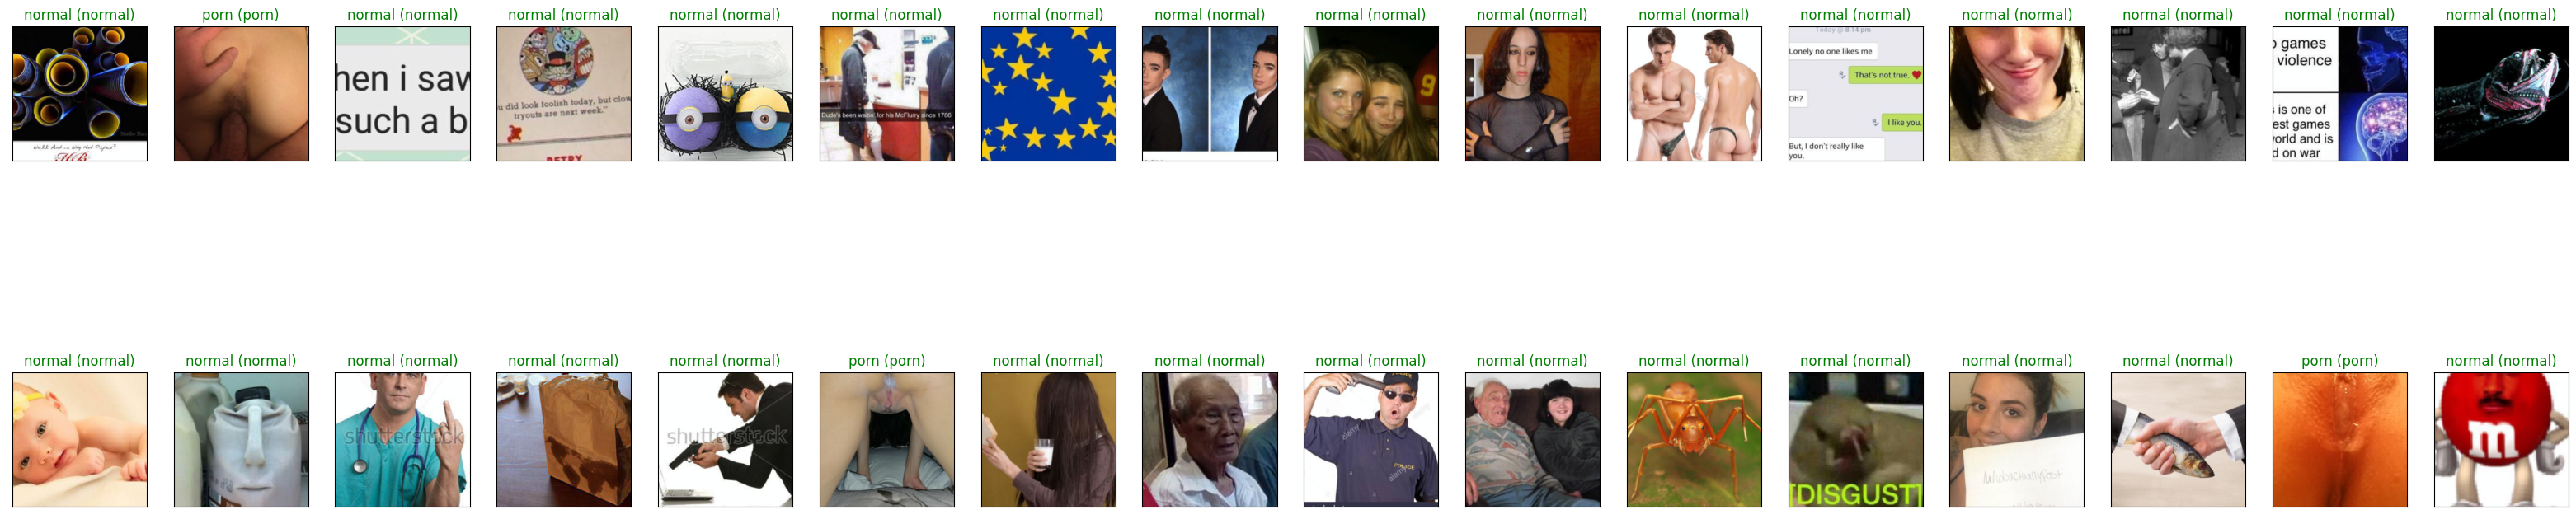

In [10]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(40, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(net,val_loader,device)